# Загрузка библиотек

In [ ]:
!git clone https://github.com/WillKoehrsen/feature-selector.git

fatal: destination path 'feature-selector' already exists and is not an empty directory.


In [ ]:
!pip install lightgbm

In [ ]:
!pip install tabgan

In [ ]:
!pip install lightgbm --upgrade

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import tabgan
import lightgbm as lgb

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Фильтрация данных

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
df = pd.read_excel('/content/medical_data.xlsx')

In [ ]:
df.head()

,Patient,ВК,ПИКС,Elongation,Flatness,LeastAxisLength,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,...,SmallAreaHighGrayLevelEmphasis.1,SmallAreaLowGrayLevelEmphasis.1,ZoneEntropy.1,ZonePercentage.1,ZoneVariance.1,Busyness.1,Coarseness.1,Complexity.1,Contrast.3,Strength.1
0,Акулов Андрей Александрович,1,NaN,0.470,NaN,NaN,10.761,10.915,13.288,10.441,...,484.751,0.015,5.404,0.780,0.396,0.017,0.073,2035.194,0.338,47.442
1,Аплин Рамиль Зиннурович,1,NaN,0.188,NaN,NaN,33.179,12.948,12.948,29.683,...,479.901,0.009,5.786,0.754,0.836,0.029,0.035,1706.733,0.176,23.631
2,Афонькин АН,1,NaN,0.259,0.000,0.000,22.743,11.474,10.950,20.340,...,943.677,0.012,5.496,0.884,0.175,0.019,0.054,4315.769,0.769,43.019
3,Базоркин ТМ,1,NaN,0.253,0.000,0.000,35.266,21.529,14.963,32.702,...,307.173,0.029,5.736,0.665,0.882,0.019,0.095,832.462,0.235,44.636
4,Бахман Александр Генрихович,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(38, 218)

In [ ]:
df_copy = df.copy()

In [ ]:
df_copy.drop(columns=['ВК'], inplace=True)

In [ ]:
bad_columns = df_copy.columns[:df_copy.shape[1]//2+1]
good_columns = df_copy.columns[df_copy.shape[1]//2+1:]

In [ ]:
df_bad = df_copy[bad_columns]
df_good = df_copy[good_columns]

In [ ]:
df_good[str(df_copy.columns[0])] = df_copy.iloc[:,0]
df_good = df_good.reindex(columns=[str(df_copy.columns[0]), *list(good_columns)])

<ipython-input-138-bbc6c34888f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good[str(df_copy.columns[0])] = df_copy.iloc[:,0]


In [ ]:
df_bad.head()

,Patient,ПИКС,Elongation,Flatness,LeastAxisLength,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,...,SmallAreaHighGrayLevelEmphasis,SmallAreaLowGrayLevelEmphasis,ZoneEntropy,ZonePercentage,ZoneVariance,Busyness,Coarseness,Complexity,Contrast.1,Strength
0,Акулов Андрей Александрович,NaN,0.470,NaN,NaN,10.761,10.915,13.288,10.441,13.990,...,823.852,0.007,5.139,0.901,0.097,0.013,0.084,3098.392,1.179,72.428
1,Аплин Рамиль Зиннурович,NaN,0.188,NaN,NaN,33.179,12.948,12.948,29.683,30.791,...,1271.920,0.007,5.967,0.822,0.299,0.015,0.041,5029.210,0.520,42.825
2,Афонькин АН,NaN,0.259,0.000,0.000,22.743,11.474,10.950,20.340,21.299,...,1899.093,0.009,5.947,0.834,0.381,0.006,0.068,7870.800,0.876,117.703
3,Базоркин ТМ,NaN,0.253,0.000,0.000,35.266,21.529,14.963,32.702,34.155,...,851.300,0.012,6.044,0.677,1.483,0.008,0.074,1404.467,0.177,61.436
4,Бахман Александр Генрихович,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_good.head()

,Patient,ЗД,Elongation.1,Flatness.1,LeastAxisLength.1,MajorAxisLength.1,Maximum2DDiameterColumn.1,Maximum2DDiameterRow.1,Maximum2DDiameterSlice.1,Maximum3DDiameter.1,...,SmallAreaHighGrayLevelEmphasis.1,SmallAreaLowGrayLevelEmphasis.1,ZoneEntropy.1,ZonePercentage.1,ZoneVariance.1,Busyness.1,Coarseness.1,Complexity.1,Contrast.3,Strength.1
0,Акулов Андрей Александрович,NaN,0.767,NaN,NaN,10.948,13.288,12.820,11.871,15.122,...,484.751,0.015,5.404,0.780,0.396,0.017,0.073,2035.194,0.338,47.442
1,Аплин Рамиль Зиннурович,NaN,0.276,NaN,NaN,31.213,17.990,13.435,29.122,30.177,...,479.901,0.009,5.786,0.754,0.836,0.029,0.035,1706.733,0.176,23.631
2,Афонькин АН,NaN,0.223,0.000,0.000,22.989,9.172,15.657,20.829,21.664,...,943.677,0.012,5.496,0.884,0.175,0.019,0.054,4315.769,0.769,43.019
3,Базоркин ТМ,NaN,0.409,NaN,NaN,17.755,13.437,13.947,17.524,19.685,...,307.173,0.029,5.736,0.665,0.882,0.019,0.095,832.462,0.235,44.636
4,Бахман Александр Генрихович,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Columns: 217 entries, Patient  to Strength.1
dtypes: float64(216), object(1)
memory usage: 64.5+ KB


In [ ]:
df.describe()

,ВК,ПИКС,Elongation,Flatness,LeastAxisLength,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,...,SmallAreaHighGrayLevelEmphasis.1,SmallAreaLowGrayLevelEmphasis.1,ZoneEntropy.1,ZonePercentage.1,ZoneVariance.1,Busyness.1,Coarseness.1,Complexity.1,Contrast.3,Strength.1
count,38.000,0.000,33.000,15.000,15.000,33.000,33.000,33.000,33.000,33.000,...,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000
mean,0.684,NaN,0.218,0.000,0.000,26.508,16.094,12.421,24.070,25.533,...,632.591,0.017,5.602,0.770,0.708,0.027,0.063,2727.700,0.401,45.535
std,0.471,NaN,0.084,0.000,0.000,7.527,5.769,2.658,6.569,6.001,...,471.644,0.012,0.305,0.084,0.799,0.020,0.022,2691.107,0.273,25.855
min,0.000,NaN,0.097,0.000,0.000,10.761,10.248,10.119,10.441,13.990,...,64.137,0.004,4.704,0.562,0.125,0.007,0.028,276.111,0.095,12.755
25%,0.000,NaN,0.159,0.000,0.000,21.795,11.124,10.889,19.791,21.299,...,339.783,0.010,5.435,0.739,0.319,0.017,0.047,1166.400,0.235,24.389
50%,1.000,NaN,0.189,0.000,0.000,25.806,14.479,11.503,23.348,24.738,...,479.901,0.014,5.621,0.780,0.426,0.022,0.058,1761.114,0.335,38.119
75%,1.000,NaN,0.259,0.000,0.000,31.515,20.774,12.948,28.492,29.478,...,840.183,0.017,5.740,0.829,0.721,0.031,0.080,2882.335,0.467,69.538
max,1.000,NaN,0.470,0.000,0.000,40.627,30.149,23.511,36.074,36.680,...,2544.573,0.072,6.267,0.899,3.730,0.117,0.115,11448.664,1.447,108.623


In [ ]:
df_copy.isna().sum().to_frame()

,0
Patient,0
ПИКС,38
Elongation,5
Flatness,23
LeastAxisLength,23
...,...
Busyness.1,5
Coarseness.1,5
Complexity.1,5
Contrast.3,5


In [ ]:
df_copy.isnull().sum() / len(df)

Patient           0.000
ПИКС              1.000
Elongation        0.132
Flatness          0.605
LeastAxisLength   0.605
                   ... 
Busyness.1        0.132
Coarseness.1      0.132
Complexity.1      0.132
Contrast.3        0.132
Strength.1        0.132
Length: 217, dtype: float64

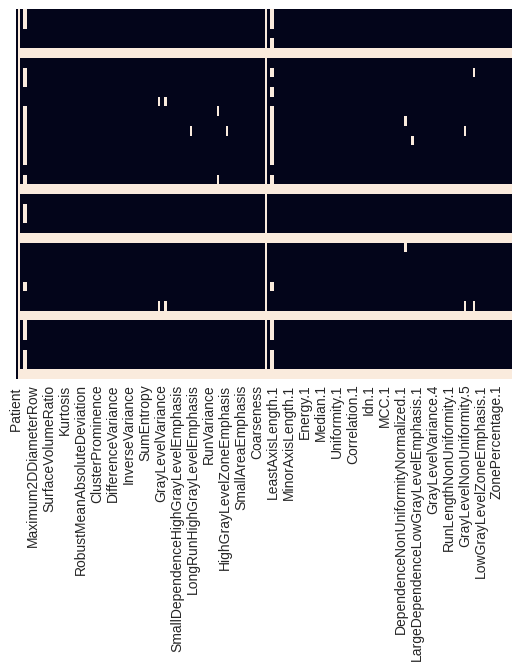

In [ ]:
sns.heatmap(df_copy.isnull(), cbar=False, yticklabels=False);

In [ ]:
threshold = 0.75

df_copy = df_copy.dropna(thresh=threshold * df_copy.shape[0], axis=1)
df_copy = df_copy.dropna(thresh=threshold * df_copy.shape[1], axis=0)

In [ ]:
df_copy.shape

(33, 211)

In [ ]:
df_copy = df_copy.fillna(df_copy.mean())

<ipython-input-148-afd4cd16e0b8>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_copy = df_copy.fillna(df_copy.mean())


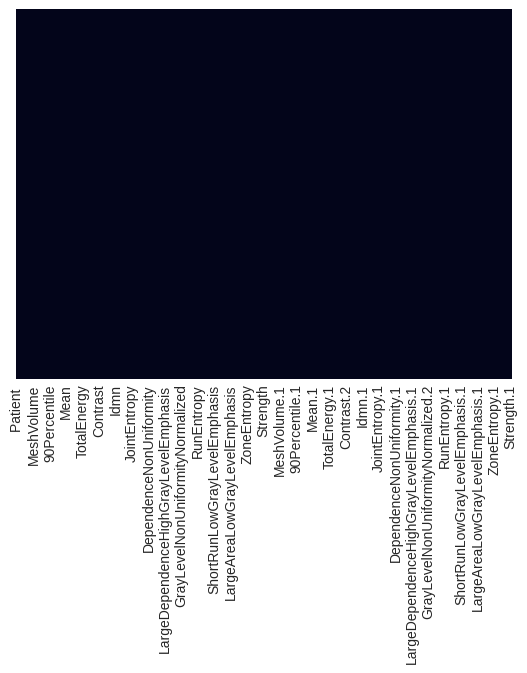

In [ ]:
sns.heatmap(df_copy.isnull(), cbar=False, yticklabels=False);

In [ ]:
df_copy.head()

,Patient,Elongation,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,MeshVolume,MinorAxisLength,Sphericity,...,SmallAreaHighGrayLevelEmphasis.1,SmallAreaLowGrayLevelEmphasis.1,ZoneEntropy.1,ZonePercentage.1,ZoneVariance.1,Busyness.1,Coarseness.1,Complexity.1,Contrast.3,Strength.1
0,Акулов Андрей Александрович,0.470,10.761,10.915,13.288,10.441,13.990,331.890,5.056,0.720,...,484.751,0.015,5.404,0.780,0.396,0.017,0.073,2035.194,0.338,47.442
1,Аплин Рамиль Зиннурович,0.188,33.179,12.948,12.948,29.683,30.791,1149.790,6.253,0.591,...,479.901,0.009,5.786,0.754,0.836,0.029,0.035,1706.733,0.176,23.631
2,Афонькин АН,0.259,22.743,11.474,10.950,20.340,21.299,609.370,5.895,0.619,...,943.677,0.012,5.496,0.884,0.175,0.019,0.054,4315.769,0.769,43.019
3,Базоркин ТМ,0.253,35.266,21.529,14.963,32.702,34.155,2334.312,8.935,0.652,...,307.173,0.029,5.736,0.665,0.882,0.019,0.095,832.462,0.235,44.636
5,Белевцев Борис Андреевич,0.146,22.190,20.774,10.278,19.149,20.910,397.489,3.238,0.507,...,339.783,0.024,5.632,0.783,0.477,0.041,0.045,1841.736,0.447,27.419


In [ ]:
threshold = 0.75

df_bad = df_bad.dropna(thresh=threshold * df_bad.shape[0], axis=1)
df_bad = df_bad.dropna(thresh=threshold * df_bad.shape[1], axis=0)
df_bad = df_bad.fillna(df_copy.mean())

df_good = df_good.dropna(thresh=threshold * df_good.shape[0], axis=1)
df_good = df_good.dropna(thresh=threshold * df_good.shape[1], axis=0)
df_good = df_good.fillna(df_copy.mean())

<ipython-input-151-bb964029c6c1>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_bad = df_bad.fillna(df_copy.mean())
<ipython-input-151-bb964029c6c1>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_good = df_good.fillna(df_copy.mean())


In [ ]:
df_bad.head()

,Patient,Elongation,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,MeshVolume,MinorAxisLength,Sphericity,...,SmallAreaHighGrayLevelEmphasis,SmallAreaLowGrayLevelEmphasis,ZoneEntropy,ZonePercentage,ZoneVariance,Busyness,Coarseness,Complexity,Contrast.1,Strength
0,Акулов Андрей Александрович,0.470,10.761,10.915,13.288,10.441,13.990,331.890,5.056,0.720,...,823.852,0.007,5.139,0.901,0.097,0.013,0.084,3098.392,1.179,72.428
1,Аплин Рамиль Зиннурович,0.188,33.179,12.948,12.948,29.683,30.791,1149.790,6.253,0.591,...,1271.920,0.007,5.967,0.822,0.299,0.015,0.041,5029.210,0.520,42.825
2,Афонькин АН,0.259,22.743,11.474,10.950,20.340,21.299,609.370,5.895,0.619,...,1899.093,0.009,5.947,0.834,0.381,0.006,0.068,7870.800,0.876,117.703
3,Базоркин ТМ,0.253,35.266,21.529,14.963,32.702,34.155,2334.312,8.935,0.652,...,851.300,0.012,6.044,0.677,1.483,0.008,0.074,1404.467,0.177,61.436
5,Белевцев Борис Андреевич,0.146,22.190,20.774,10.278,19.149,20.910,397.489,3.238,0.507,...,493.444,0.022,5.102,0.792,0.292,0.010,0.146,915.846,0.527,82.985


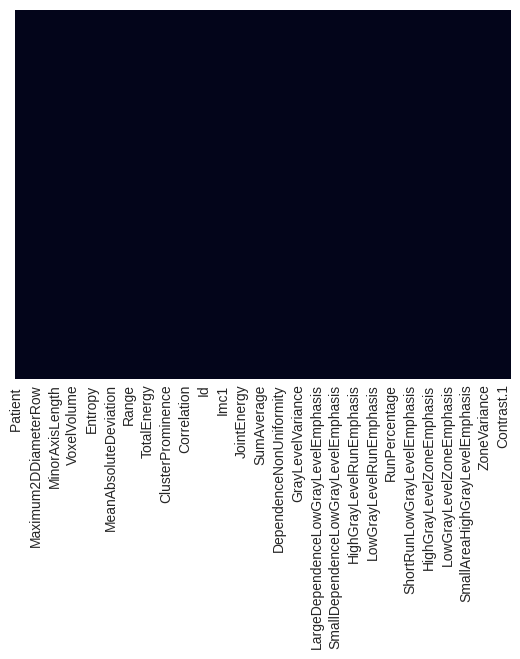

In [ ]:
sns.heatmap(df_bad.isnull(), cbar=False, yticklabels=False);

In [ ]:
df_good.head()

,Patient,Elongation.1,MajorAxisLength.1,Maximum2DDiameterColumn.1,Maximum2DDiameterRow.1,Maximum2DDiameterSlice.1,Maximum3DDiameter.1,MeshVolume.1,MinorAxisLength.1,Sphericity.1,...,SmallAreaHighGrayLevelEmphasis.1,SmallAreaLowGrayLevelEmphasis.1,ZoneEntropy.1,ZonePercentage.1,ZoneVariance.1,Busyness.1,Coarseness.1,Complexity.1,Contrast.3,Strength.1
0,Акулов Андрей Александрович,0.767,10.948,13.288,12.820,11.871,15.122,644.283,8.395,0.811,...,484.751,0.015,5.404,0.780,0.396,0.017,0.073,2035.194,0.338,47.442
1,Аплин Рамиль Зиннурович,0.276,31.213,17.990,13.435,29.122,30.177,1938.058,8.624,0.716,...,479.901,0.009,5.786,0.754,0.836,0.029,0.035,1706.733,0.176,23.631
2,Афонькин АН,0.223,22.989,9.172,15.657,20.829,21.664,592.226,5.128,0.658,...,943.677,0.012,5.496,0.884,0.175,0.019,0.054,4315.769,0.769,43.019
3,Базоркин ТМ,0.409,17.755,13.437,13.947,17.524,19.685,912.680,7.268,0.741,...,307.173,0.029,5.736,0.665,0.882,0.019,0.095,832.462,0.235,44.636
5,Белевцев Борис Андреевич,0.320,23.766,12.755,18.727,23.392,24.778,1222.238,7.593,0.652,...,339.783,0.024,5.632,0.783,0.477,0.041,0.045,1841.736,0.447,27.419


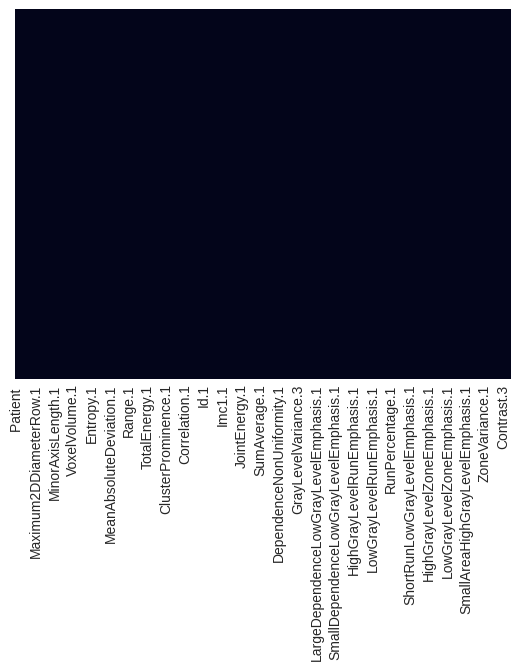

In [ ]:
sns.heatmap(df_good.isnull(), cbar=False, yticklabels=False);

# Статистический анализ

In [ ]:
df_bad.describe()

,Elongation,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,MeshVolume,MinorAxisLength,Sphericity,SurfaceArea,...,SmallAreaHighGrayLevelEmphasis,SmallAreaLowGrayLevelEmphasis,ZoneEntropy,ZonePercentage,ZoneVariance,Busyness,Coarseness,Complexity,Contrast.1,Strength
count,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,...,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000
mean,0.218,26.508,16.094,12.421,24.070,25.533,877.674,5.451,0.590,724.824,...,1059.179,0.013,5.534,0.823,0.398,0.017,0.071,5095.966,0.808,69.280
std,0.084,7.527,5.769,2.658,6.569,6.001,494.601,1.718,0.079,239.151,...,860.865,0.007,0.458,0.071,0.322,0.010,0.026,7455.489,1.130,46.806
min,0.097,10.761,10.248,10.119,10.441,13.990,231.542,2.738,0.464,322.070,...,181.490,0.005,4.445,0.673,0.051,0.006,0.033,400.735,0.177,17.133
25%,0.159,21.795,11.124,10.889,19.791,21.299,532.246,3.989,0.532,561.934,...,493.444,0.008,5.301,0.792,0.190,0.010,0.057,1383.966,0.264,35.044
50%,0.189,25.806,14.479,11.503,23.348,24.738,664.810,5.589,0.578,656.521,...,720.548,0.012,5.455,0.825,0.292,0.014,0.068,2377.750,0.494,54.670
75%,0.259,31.515,20.774,12.948,28.492,29.478,1209.078,6.568,0.647,943.639,...,1271.920,0.018,5.926,0.878,0.476,0.018,0.087,5464.501,0.836,83.206
max,0.470,40.627,30.149,23.511,36.074,36.680,2334.312,9.068,0.775,1305.926,...,3428.510,0.031,6.500,0.949,1.483,0.046,0.146,34544.141,5.718,212.014


In [ ]:
df_good.describe()

,Elongation.1,MajorAxisLength.1,Maximum2DDiameterColumn.1,Maximum2DDiameterRow.1,Maximum2DDiameterSlice.1,Maximum3DDiameter.1,MeshVolume.1,MinorAxisLength.1,Sphericity.1,SurfaceArea.1,...,SmallAreaHighGrayLevelEmphasis.1,SmallAreaLowGrayLevelEmphasis.1,ZoneEntropy.1,ZonePercentage.1,ZoneVariance.1,Busyness.1,Coarseness.1,Complexity.1,Contrast.3,Strength.1
count,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,...,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000
mean,0.258,28.333,15.079,15.898,26.056,27.431,1088.978,6.517,0.636,814.020,...,632.591,0.017,5.602,0.770,0.708,0.027,0.063,2727.700,0.401,45.535
std,0.119,12.320,6.775,6.666,10.381,9.760,523.237,2.014,0.091,339.206,...,471.644,0.012,0.305,0.084,0.799,0.020,0.022,2691.107,0.273,25.855
min,0.119,10.948,9.172,10.249,11.871,15.122,411.125,3.661,0.430,404.706,...,64.137,0.004,4.704,0.562,0.125,0.007,0.028,276.111,0.095,12.755
25%,0.188,21.319,11.287,12.053,20.551,21.664,770.045,5.142,0.587,600.767,...,339.783,0.010,5.435,0.739,0.319,0.017,0.047,1166.400,0.235,24.389
50%,0.240,23.766,12.487,13.435,22.832,24.347,940.664,6.251,0.652,724.687,...,479.901,0.014,5.621,0.780,0.426,0.022,0.058,1761.114,0.335,38.119
75%,0.287,33.780,15.706,15.657,30.010,30.907,1222.238,7.357,0.704,873.856,...,840.183,0.017,5.740,0.829,0.721,0.031,0.080,2882.335,0.467,69.538
max,0.767,72.996,37.768,35.938,61.967,62.093,2380.209,14.799,0.811,1860.678,...,2544.573,0.072,6.267,0.899,3.730,0.117,0.115,11448.664,1.447,108.623


# U-test

In [ ]:
def u_test(parametr, data_1, data_2):
  result = stats.mannwhitneyu(list(data_1), list(data_2), alternative='two-sided')

  return {'parametr': parametr,
          'statistic': result[0],
          'pvalue': result[1]
          }

In [ ]:
numpy_bad = df_bad.to_numpy()[:,1:]
numpy_good = df_good.to_numpy()[:,1:]

In [ ]:
result = list(map(u_test, df_bad.columns[1:], numpy_bad.T, numpy_good.T))

In [ ]:
df_u_test = pd.DataFrame()

In [ ]:
for parametr in result:
  if parametr['pvalue'] > 0.05:
    df_hypothesis = pd.DataFrame({'parametr': [parametr['parametr']],
                                  'statistic': [parametr['statistic']],
                                  'pvalue': [parametr['pvalue']],
                                  'hypothesis': 'H0'
                                })
  else:
    df_hypothesis = pd.DataFrame({'parametr': [parametr['parametr']],
                                  'statistic': [parametr['statistic']],
                                  'pvalue': [parametr['pvalue']],
                                  'hypothesis': 'H1'
                                })

  df_u_test = pd.concat([df_u_test, df_hypothesis])

df_u_test.reset_index(inplace=True)
df_u_test.drop(columns=['index'], inplace=True)

In [ ]:
df_u_test

,parametr,statistic,pvalue,hypothesis
0,Elongation,407.000,0.079,H0
1,MajorAxisLength,536.000,0.918,H0
2,Maximum2DDiameterColumn,600.500,0.477,H0
3,Maximum2DDiameterRow,296.000,0.001,H1
4,Maximum2DDiameterSlice,506.500,0.631,H0
...,...,...,...,...
100,Busyness,309.000,0.003,H1
101,Coarseness,641.000,0.218,H0
102,Complexity,637.000,0.238,H0
103,Contrast.1,699.000,0.048,H1


In [ ]:
df_u_test.groupby(['hypothesis'], group_keys=True).agg(['count'])

,parametr,statistic,pvalue
,count,count,count
hypothesis,,,
H0,62,62,62
H1,43,43,43


In [ ]:
# df_u_test.to_excel("U_test.xlsx")

# Выбор более информативных признаков c помощью feature-selector

In [ ]:
bad_labels = np.zeros(df_bad.shape[0])
good_labels = np.ones(df_good.shape[0])

In [ ]:
from feature_selector import FeatureSelector

## Для ПИКС

In [ ]:
fs = FeatureSelector(data = df_bad, labels = bad_labels)

In [ ]:
fs.identify_missing(missing_threshold = 0.6)

0 features with greater than 0.60 missing values.



In [ ]:
fs.missing_stats.head()

,missing_fraction
Patient,0.000
RunLengthNonUniformityNormalized,0.000
RunEntropy,0.000
LowGrayLevelRunEmphasis,0.000
LongRunLowGrayLevelEmphasis,0.000


In [ ]:
fs.identify_collinear(correlation_threshold = 0.98)

36 features with a correlation magnitude greater than 0.98.



/content/feature_selector.py:193: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = self.data.corr()
/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_inde

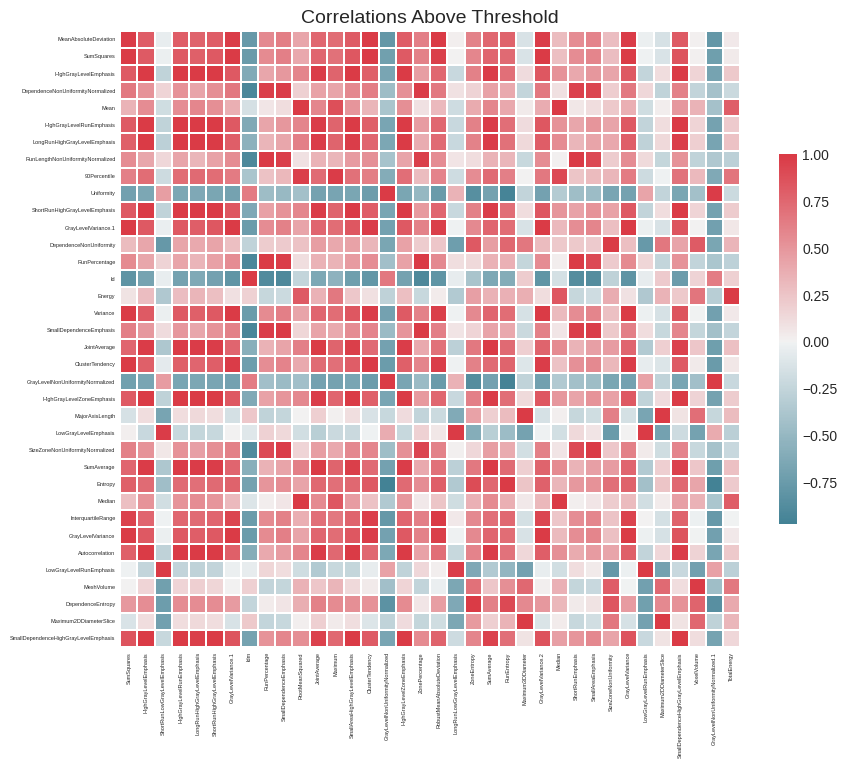

In [ ]:
fs.plot_collinear()

In [ ]:
# список признаков для удаления
collinear_features = fs.ops['collinear']

# датафрейм коллинеарных признаков
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,Maximum2DDiameterSlice,MajorAxisLength,0.995
1,Maximum3DDiameter,MajorAxisLength,0.992
2,Maximum3DDiameter,Maximum2DDiameterSlice,0.999
3,VoxelVolume,MeshVolume,0.999
4,Maximum,90Percentile,0.980


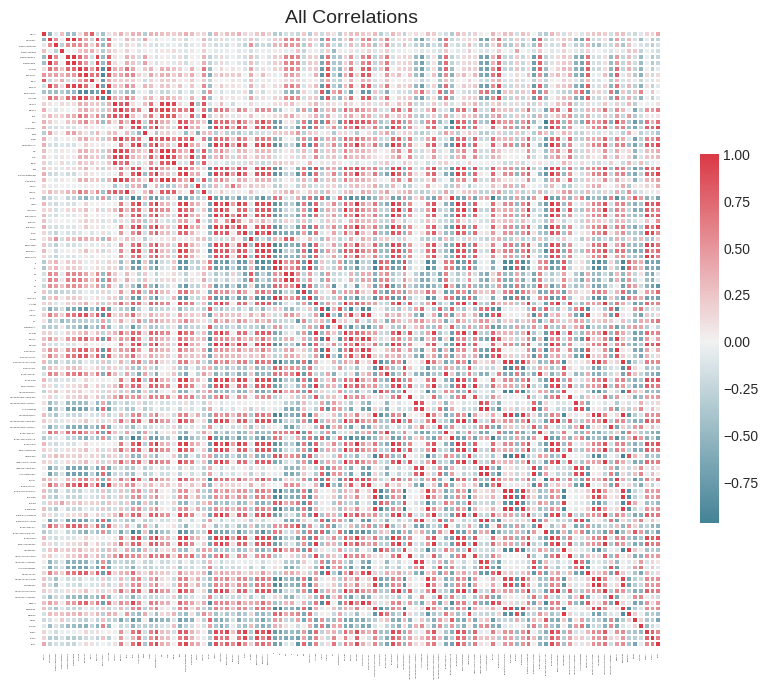

In [ ]:
fs.plot_collinear(plot_all=True)

## Для ЭД

In [ ]:
fs = FeatureSelector(data = df_good, labels = good_labels)

In [ ]:
fs.identify_missing(missing_threshold = 0.6)

0 features with greater than 0.60 missing values.



In [ ]:
fs.missing_stats.head()

,missing_fraction
Patient,0.000
RunLengthNonUniformityNormalized.1,0.000
RunEntropy.1,0.000
LowGrayLevelRunEmphasis.1,0.000
LongRunLowGrayLevelEmphasis.1,0.000


In [ ]:
fs.identify_collinear(correlation_threshold = 0.98)

40 features with a correlation magnitude greater than 0.98.



/content/feature_selector.py:193: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = self.data.corr()
/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_inde

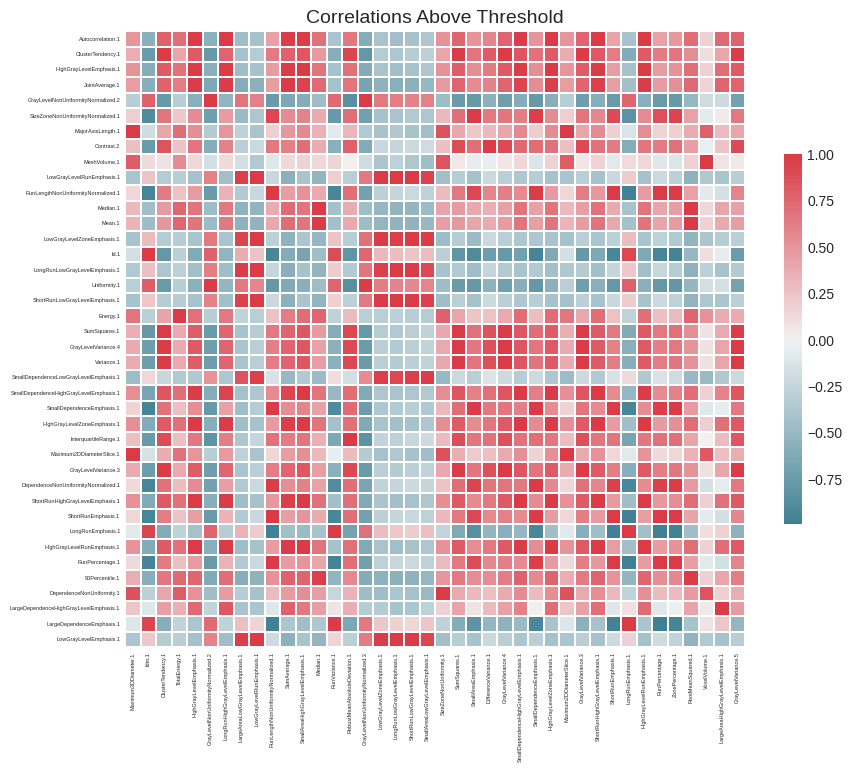

In [ ]:
fs.plot_collinear()

In [ ]:
# список признаков для удаления
collinear_features = fs.ops['collinear']

# датафрейм коллинеарных признаков
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,Maximum2DDiameterSlice.1,MajorAxisLength.1,0.996
1,Maximum3DDiameter.1,MajorAxisLength.1,0.995
2,Maximum3DDiameter.1,Maximum2DDiameterSlice.1,0.999
3,VoxelVolume.1,MeshVolume.1,0.999
4,Median.1,Mean.1,0.996


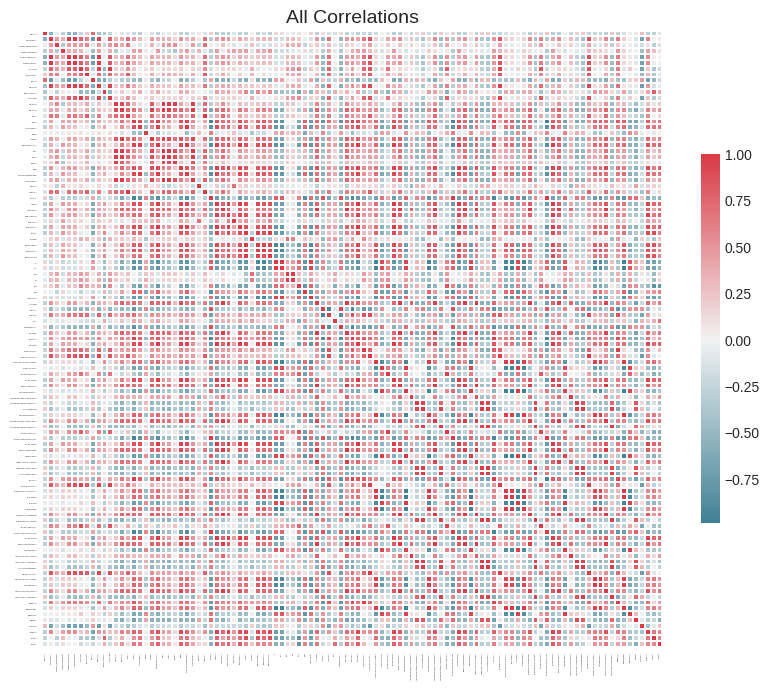

In [ ]:
fs.plot_collinear(plot_all=True)

## Выбор признаков для всего датасета

In [ ]:
df_bad_copy = df_bad.copy()
df_good_copy = df_good.copy()

In [ ]:
df_good_copy.columns = list(df_bad_copy.columns)

In [ ]:
df_bad_copy['label'] = bad_labels
df_good_copy['label'] = good_labels

In [ ]:
new_df = pd.concat([df_bad_copy, df_good_copy], ignore_index=True)

In [ ]:
new_df.head()

,Patient,Elongation,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,MeshVolume,MinorAxisLength,Sphericity,...,SmallAreaLowGrayLevelEmphasis,ZoneEntropy,ZonePercentage,ZoneVariance,Busyness,Coarseness,Complexity,Contrast.1,Strength,label
0,Акулов Андрей Александрович,0.470,10.761,10.915,13.288,10.441,13.990,331.890,5.056,0.720,...,0.007,5.139,0.901,0.097,0.013,0.084,3098.392,1.179,72.428,0.000
1,Аплин Рамиль Зиннурович,0.188,33.179,12.948,12.948,29.683,30.791,1149.790,6.253,0.591,...,0.007,5.967,0.822,0.299,0.015,0.041,5029.210,0.520,42.825,0.000
2,Афонькин АН,0.259,22.743,11.474,10.950,20.340,21.299,609.370,5.895,0.619,...,0.009,5.947,0.834,0.381,0.006,0.068,7870.800,0.876,117.703,0.000
3,Базоркин ТМ,0.253,35.266,21.529,14.963,32.702,34.155,2334.312,8.935,0.652,...,0.012,6.044,0.677,1.483,0.008,0.074,1404.467,0.177,61.436,0.000
4,Белевцев Борис Андреевич,0.146,22.190,20.774,10.278,19.149,20.910,397.489,3.238,0.507,...,0.022,5.102,0.792,0.292,0.010,0.146,915.846,0.527,82.985,0.000


In [ ]:
new_df = new_df.sample(frac=1).reset_index(drop=True)

In [ ]:
new_df.head()

,Patient,Elongation,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,MeshVolume,MinorAxisLength,Sphericity,...,SmallAreaLowGrayLevelEmphasis,ZoneEntropy,ZonePercentage,ZoneVariance,Busyness,Coarseness,Complexity,Contrast.1,Strength,label
0,Людкевич ИИ (Р),0.200,36.577,25.429,11.288,31.950,32.795,1207.739,7.298,0.570,...,0.008,5.749,0.748,0.864,0.017,0.058,1785.574,0.237,35.044,0.000
1,Иржанова Кафия Агисовна,0.252,16.227,11.287,11.287,14.518,17.130,421.621,4.083,0.640,...,0.032,4.996,0.847,0.426,0.033,0.094,1166.400,0.467,38.119,1.000
2,Лепкалов СН,0.197,41.909,37.768,11.776,38.238,38.666,2066.724,8.242,0.618,...,0.005,5.497,0.747,0.543,0.034,0.047,786.895,0.164,17.609,1.000
3,Сапего ВС,0.205,41.704,12.275,33.218,39.719,40.211,2066.310,8.536,0.507,...,0.009,6.199,0.799,0.430,0.023,0.029,6304.311,0.403,35.728,1.000
4,Романов Михаил Михайлович,0.162,40.627,15.595,11.288,35.531,36.293,1137.820,6.568,0.518,...,0.005,5.895,0.872,0.278,0.008,0.036,8415.420,0.585,66.734,0.000


In [ ]:
X = new_df.iloc[:,1:-1]
X = (X - X.mean()) / X.std()

y = new_df['label']

In [ ]:
fs = FeatureSelector(data = X, labels = y)

### Пропущенные значения

In [ ]:
fs.identify_missing(missing_threshold = 0.6)

0 features with greater than 0.60 missing values.



In [ ]:
fs.missing_stats.head()

,missing_fraction
Elongation,0.000
SumSquares,0.000
RunLengthNonUniformity,0.000
RunEntropy,0.000
LowGrayLevelRunEmphasis,0.000


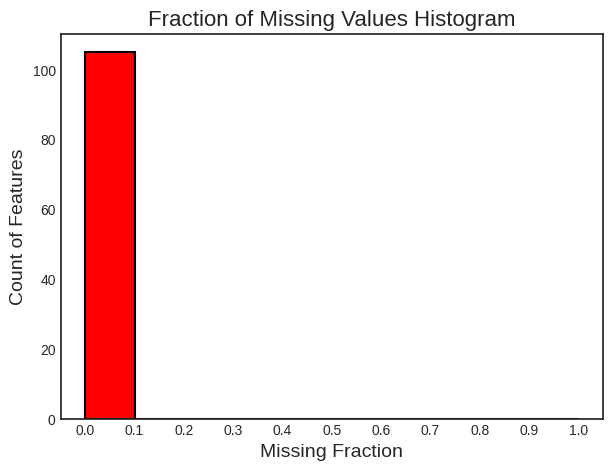

In [ ]:
fs.plot_missing()

### Коллинеарные признаки

In [ ]:
fs.identify_collinear(correlation_threshold = 0.98)

33 features with a correlation magnitude greater than 0.98.



/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/feature_selector.py:223

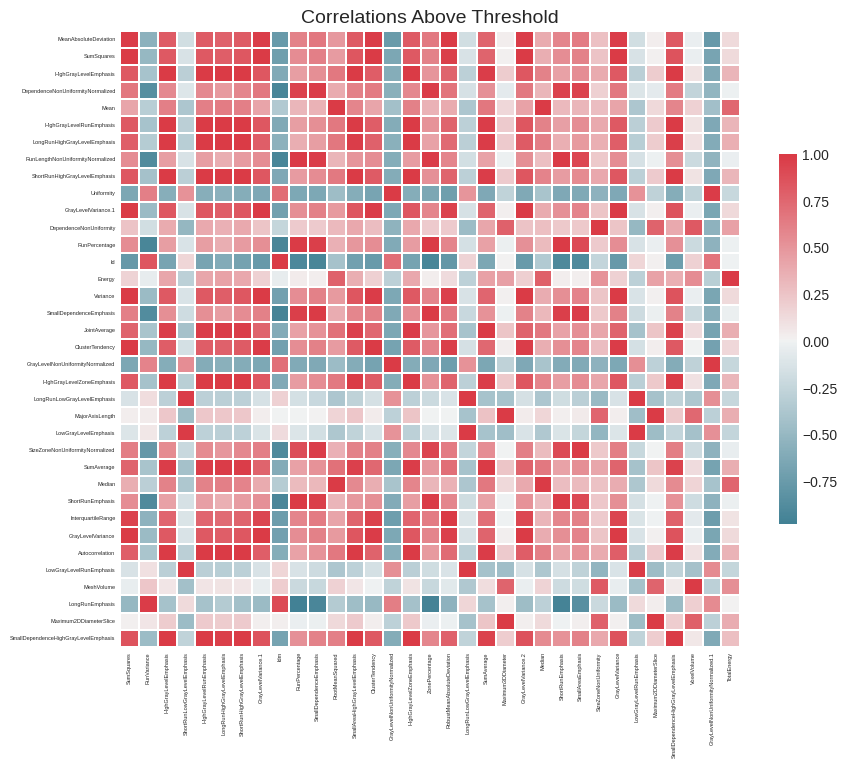

In [ ]:
fs.plot_collinear()

In [ ]:
# список признаков для удаления
collinear_features = fs.ops['collinear']

# датафрейм коллинеарных признаков
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,Maximum2DDiameterSlice,MajorAxisLength,0.995
1,Maximum3DDiameter,MajorAxisLength,0.994
2,Maximum3DDiameter,Maximum2DDiameterSlice,0.999
3,VoxelVolume,MeshVolume,0.999
4,Median,Mean,0.996


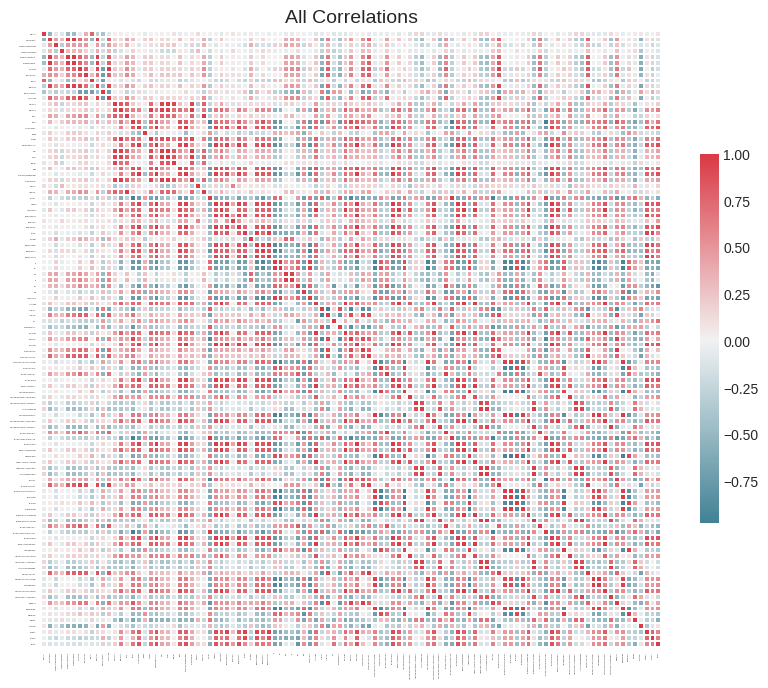

In [ ]:
fs.plot_collinear(plot_all=True)

In [ ]:
# fs.record_collinear.to_excel("collinear.xlsx")

### Признаки с нулевой важностью

Два перечисленных метода могут быть применены к любому структурированному набору данных. Они являются детерминированными, то есть результаты их работы не меняются в разных подходах.

Метод, который мы разберем сейчас, недетерминированный и предназначен только для задач контролируемого машинного обучения с обучающими метками. Функция ``` identify_zero_importance``` находит признаки, которые имеют нулевую важность. В моделях на основе деревьев решений такие параметры не используются, поэтому мы можем смело удалить их, не влияя на производительность.

FeatureSelector устанавливает важность признаков с помощью алгоритма градиентного бустинга из библиотеки LightGBM. Показатель усредняется по 10 тренировочным прогонам GBM для уменьшения дисперсии. Кроме того, используется ранняя остановка с проверочным набором, чтобы предотвратить переобучение. Эту опцию можно отключить.

In [ ]:
# lgb_params = {
#   'n_jobs': -1,
#   'n_estimators': 2000,
#   'learning_rate': 0.05,
#   'importance_type': 'split',
#   'early_stopping_rounds': 100,
#   'verbose': -1
# }

In [ ]:
fs.identify_zero_importance(task = 'classification',
                            eval_metric = 'auc',
                            n_iterations = 10,
                            early_stopping = True)

zero_importance_features = fs.ops['zero_importance']

Training Gradient Boosting Model


77 features with zero or negative importance after one-hot encoding.



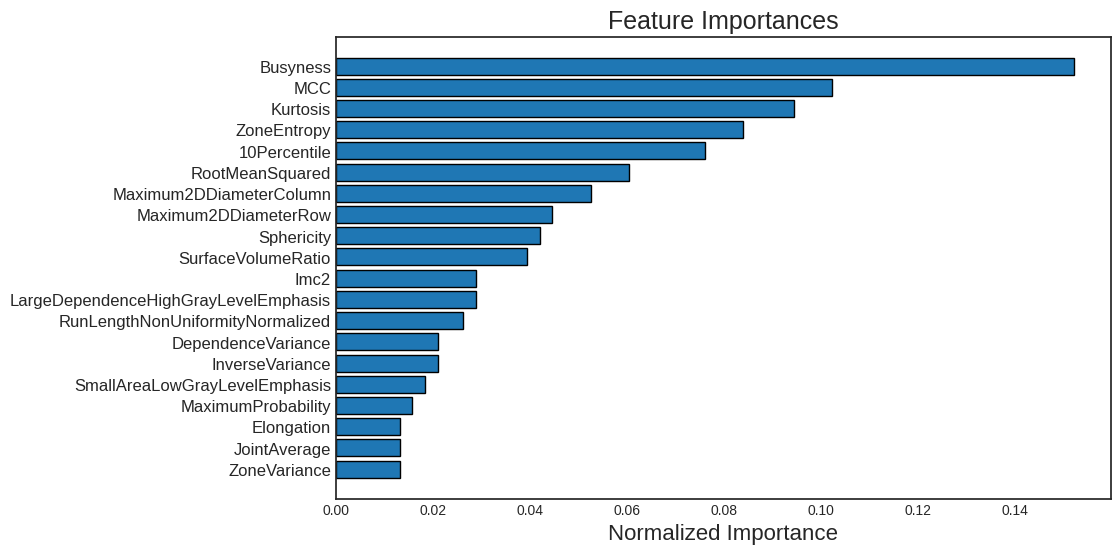

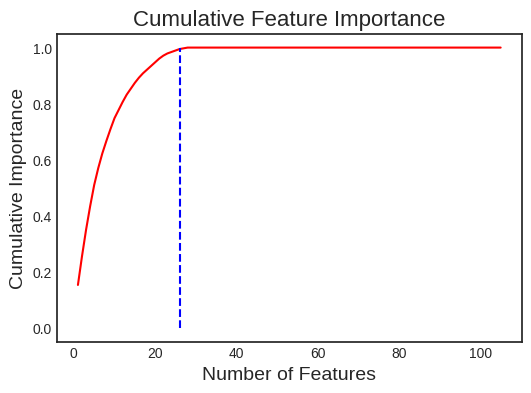

26 features required for 0.99 of cumulative importance


In [ ]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 20)

In [ ]:
fs.feature_importances.head(20)

,feature,importance,normalized_importance,cumulative_importance
0,Busyness,5.800,0.152,0.152
1,MCC,3.900,0.102,0.255
2,Kurtosis,3.600,0.094,0.349
3,ZoneEntropy,3.200,0.084,0.433
4,10Percentile,2.900,0.076,0.509
5,RootMeanSquared,2.300,0.060,0.570
6,Maximum2DDiameterColumn,2.000,0.052,0.622
7,Maximum2DDiameterRow,1.700,0.045,0.667
8,Sphericity,1.600,0.042,0.709
9,SurfaceVolumeRatio,1.500,0.039,0.748


In [ ]:
fs.feature_importances.to_excel("zero_importance_features.xlsx")

### Признаки с низкой важностью

Функция ```low_importance``` основывается на том же подходе, что и метод главных компонент (PCA).

In [ ]:
fs.identify_low_importance(cumulative_importance = 0.98)

17 features required for cumulative importance of 0.98 after one hot encoding.
88 features do not contribute to cumulative importance of 0.98.



In [ ]:
fs.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,MCC,4.000,0.161,0.161
1,Busyness,3.500,0.141,0.302
2,ZoneEntropy,3.500,0.141,0.444
3,Sphericity,2.800,0.113,0.556
4,Maximum2DDiameterColumn,1.500,0.060,0.617
5,Kurtosis,1.300,0.052,0.669
6,Maximum2DDiameterRow,1.000,0.040,0.710
7,10Percentile,1.000,0.040,0.750
8,RunLengthNonUniformityNormalized,0.900,0.036,0.786
9,SmallAreaLowGrayLevelEmphasis,0.900,0.036,0.823


In [ ]:
# fs.feature_importances.to_excel("identify_low_importance.xlsx")

### Признаки с единственным значением

In [ ]:
fs.identify_single_unique()

0 features with a single unique value.



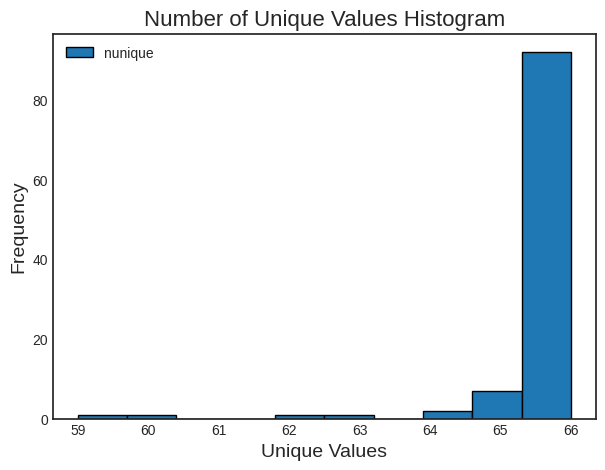

In [ ]:
fs.plot_unique()

### Отбор признаков всеми методами

In [ ]:
fs.identify_all(selection_params = {'missing_threshold': 0.6,
                                    'correlation_threshold': 0.98,
                                    'task': 'classification',
                                    'eval_metric': 'auc',
                                    'importance_type': 'split',
                                    'cumulative_importance': 0.99})

0 features with greater than 0.60 missing values.

0 features with a single unique value.

33 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model



/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/feature_selector.py:223


83 features with zero or negative importance after one-hot encoding.

19 features required for cumulative importance of 0.99 after one hot encoding.
86 features do not contribute to cumulative importance of 0.99.

90 total features out of 105 identified for removal after one-hot encoding.



### Код для удаления признаков

In [ ]:
df_informative_features = fs.remove(methods = 'all', keep_one_hot=False)

['missing', 'collinear', 'zero_importance', 'low_importance', 'single_unique'] methods have been run

Removed 90 features including one-hot features.


In [ ]:
df_informative_features

,Maximum2DDiameterColumn,Maximum2DDiameterRow,Sphericity,10Percentile,Kurtosis,Mean,JointAverage,MCC,DependenceVariance,LargeDependenceHighGrayLevelEmphasis,RunLengthNonUniformityNormalized,LargeAreaEmphasis,SmallAreaLowGrayLevelEmphasis,ZoneEntropy,Busyness
0,1.571,-0.539,-0.484,-0.296,-0.069,-0.486,0.173,-0.808,1.143,0.300,-0.702,0.436,-0.725,0.466,-0.309
1,-0.686,-0.539,0.312,-0.782,-0.445,-0.935,-1.214,-0.282,0.125,-1.069,0.679,-0.412,1.758,-1.474,0.677
2,3.541,-0.447,0.063,1.006,0.491,0.546,-0.495,-0.202,0.246,-0.456,-0.516,0.112,-0.950,-0.181,0.710
3,-0.529,3.575,-1.203,-0.722,0.025,-0.522,0.168,-0.751,-0.161,-0.010,0.054,-0.232,-0.616,1.630,0.042
4,0.001,-0.539,-1.081,2.005,2.151,1.886,3.111,-0.243,-0.668,2.452,0.980,-0.642,-0.949,0.845,-0.838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.828,-0.728,-1.204,0.237,-0.799,0.385,-0.498,1.602,-0.601,-0.510,0.210,-0.345,0.749,-1.200,-0.699
62,-0.512,-0.334,-0.299,-0.397,-0.294,-0.601,-0.845,-1.049,1.212,-0.570,-0.673,0.297,-0.211,-0.179,1.313
63,-0.845,-0.240,-1.695,-1.006,1.279,-1.299,-0.949,0.379,0.369,-0.992,0.491,0.132,0.079,-2.306,0.522
64,3.123,-0.395,-2.086,1.937,0.515,2.073,2.202,-0.528,-1.003,1.337,0.972,-0.804,-0.867,1.804,-0.743


# PCA

In [ ]:
X_centered = X - X.mean()

In [ ]:
cov_matrix = np.cov(X_centered)

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

In [ ]:
index_informative_features = np.where(eigenvalues > np.median(eigenvalues))[0]

In [ ]:
df_informative_features = X.iloc[:,list(index_informative_features)]

In [ ]:
df_informative_features.head()

,Elongation,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,MeshVolume,MinorAxisLength,Sphericity,SurfaceArea,...,Range,RobustMeanAbsoluteDeviation,RootMeanSquared,Skewness,TotalEnergy,Uniformity,Variance,Autocorrelation,ClusterProminence,ClusterShade
0,-0.370,0.900,1.571,-0.539,0.794,0.780,0.435,0.679,-0.484,0.652,...,-0.185,-0.424,-0.512,-0.103,-0.246,-0.233,-0.478,-0.062,-0.479,-0.156
1,0.130,-1.101,-0.686,-0.539,-1.215,-1.155,-1.088,-0.984,0.312,-1.170,...,-0.859,-0.562,-0.952,0.918,-0.499,0.404,-0.579,-0.895,-0.510,-0.029
2,-0.397,1.424,3.541,-0.447,1.518,1.505,2.098,1.168,0.063,1.694,...,-0.842,-0.885,0.478,-0.832,0.721,0.491,-0.755,-0.554,-0.544,-0.298
3,-0.320,1.404,-0.529,3.575,1.689,1.696,2.098,1.320,-1.203,2.638,...,0.477,0.117,-0.484,0.537,-0.005,-0.940,0.122,-0.003,-0.087,0.220
4,-0.733,1.298,0.001,-0.539,1.206,1.212,0.299,0.302,-1.081,0.842,...,1.970,0.050,1.865,-1.476,1.050,-0.632,0.451,3.604,0.447,-1.311


In [ ]:
df_informative_features.to_excel("pca.xlsx")

# Lasso

## Не стандартизированные величины

In [ ]:
clf = linear_model.Lasso(alpha=0.1)

In [ ]:
clf.fit(X, y)

Lasso(alpha=0.1)

In [ ]:
count = 0
for i in clf.coef_:
    if i != 0:
        count += 1

print(f'Модель отобрала {count} признаков. Настоящее количество информативных признаков: {X.shape[1]}')

Модель отобрала 9 признаков. Настоящее количество информативных признаков: 105


In [ ]:
index_informative_features = np.where(clf.coef_ != 0)[0]

In [ ]:
index_informative_features

array([ 3,  7, 10, 13, 26, 49, 56, 84, 88])

In [ ]:
df_informative_features = X.iloc[:,list(index_informative_features)]

In [ ]:
df_informative_features.head()

,Maximum2DDiameterRow,MinorAxisLength,SurfaceVolumeRatio,90Percentile,Skewness,MCC,DependenceNonUniformityNormalized,GrayLevelNonUniformity.2,LargeAreaEmphasis
0,-0.539,0.679,-0.308,-0.520,-0.103,-0.808,-0.767,0.602,0.436
1,-0.539,-0.984,0.643,-0.882,0.918,-0.282,0.790,-0.858,-0.412
2,-0.447,1.168,-1.129,0.169,-0.832,-0.202,-0.729,2.466,0.112
3,3.575,1.320,-0.522,-0.346,0.537,-0.751,-0.200,1.183,-0.232
4,-0.539,0.302,0.135,1.732,-1.476,-0.243,1.118,0.261,-0.642


## Стандартизированные величины

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
clf = linear_model.Lasso(alpha=0.1)

In [ ]:
clf.fit(X, y)

Lasso(alpha=0.1)

In [ ]:
count = 0
for i in clf.coef_:
    if i != 0:
        count += 1

print(f'Модель отобрала {count} признаков. Настоящее количество информативных признаков: {X.shape[1]}')

Модель отобрала 9 признаков. Настоящее количество информативных признаков: 105


In [ ]:
index_informative_features = np.where(clf.coef_ != 0)[0]

In [ ]:
index_informative_features

array([ 3,  7, 10, 13, 26, 49, 56, 84, 88])

In [ ]:
df_informative_features = X.iloc[:,list(index_informative_features)]

In [ ]:
df_informative_features.head()

,Maximum2DDiameterRow,MinorAxisLength,SurfaceVolumeRatio,90Percentile,Skewness,MCC,DependenceNonUniformityNormalized,GrayLevelNonUniformity.2,LargeAreaEmphasis
0,-0.539,0.679,-0.308,-0.520,-0.103,-0.808,-0.767,0.602,0.436
1,-0.539,-0.984,0.643,-0.882,0.918,-0.282,0.790,-0.858,-0.412
2,-0.447,1.168,-1.129,0.169,-0.832,-0.202,-0.729,2.466,0.112
3,3.575,1.320,-0.522,-0.346,0.537,-0.751,-0.200,1.183,-0.232
4,-0.539,0.302,0.135,1.732,-1.476,-0.243,1.118,0.261,-0.642


In [ ]:
# Предсказания модели на тестовом наборе
y_pred = clf.predict(X)

# Преобразуйте регрессионные предсказания в бинарные метки (например, 0 и 1) для задачи классификации
threshold = 0.5  # Порог для классификации
y_pred_class = (y_pred > threshold).astype(int)

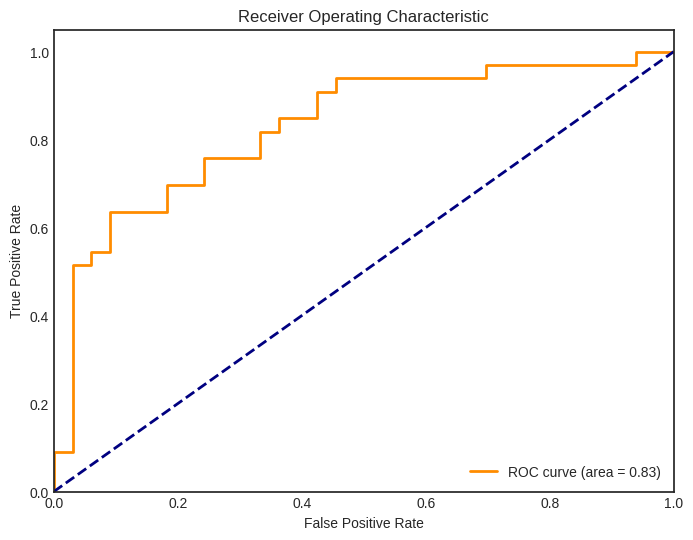

In [ ]:
# Вычисление ROC AUC
roc_auc = roc_auc_score(y, y_pred)

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y, y_pred)

# Построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# df_informative_features.to_excel("lasso.xlsx")

# Linear Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Пример данных
data = pd.read_csv('your_data.csv')  # Замените 'your_data.csv' на путь к вашему файлу с данными
X = data.drop('target', axis=1)  # Признаки
y = data['target']  # Метки классов

# Разделите данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создайте пайплайн
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Масштабирование признаков
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear'))  # Логистическая регрессия с L1-регуляризацией
])

# Обучите модель с использованием пайплайна
pipeline.fit(X_train, y_train)

# Предсказания
y_pred = pipeline.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Вывод отчета о классификации
print(classification_report(y_test, y_pred))


FileNotFoundError: ignored

# KNN

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Пример данных
data = pd.read_csv('your_data.csv')  # Замените 'your_data.csv' на путь к вашему файлу с данными
X = data.drop('target', axis=1)  # Признаки
y = data['target']  # Метки классов

# Разделите данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создайте пайплайн
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Масштабирование признаков
    ('knn', KNeighborsClassifier(n_neighbors=3))  # K-ближайших соседей
])

# Обучите модель с использованием пайплайна
pipeline.fit(X_train, y_train)

# Предсказания
y_pred = pipeline.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Вывод отчета о классификации
print(classification_report(y_test, y_pred))
